In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('data_sorted.csv')
df.head()

,success,actual_time,optimal_time,goal_x,goal_y,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,...,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,timestep
0,True,16.639,6.796149,0.0,10.0,0,2.975059,2.950377,2.938696,2.933910,...,2.950528,2.976332,-0.000009,0.000073,1.570909,0.000043,0.008641,0.006,0.000665,0
1,True,16.639,6.796149,0.0,10.0,0,2.975632,2.949891,2.938163,2.934393,...,2.949972,2.976789,-0.000009,0.000073,1.570903,0.000043,0.003630,0.012,0.001330,1
2,True,16.639,6.796149,0.0,10.0,0,2.974015,2.950373,2.940136,2.935323,...,2.951352,2.975511,-0.000009,0.000193,1.570919,0.003106,0.004454,0.018,0.001996,2
3,True,16.639,6.796149,0.0,10.0,0,2.972146,2.951025,2.939157,2.935039,...,2.950131,2.976381,-0.000009,0.000432,1.570933,0.007701,0.001190,0.024,0.002661,3
4,True,16.639,6.796149,0.0,10.0,0,2.974818,2.951458,2.940485,2.935588,...,2.950873,2.976459,-0.000009,0.000792,1.570969,0.013069,0.005987,0.030,0.003326,4


In [2]:
df.describe()

,actual_time,optimal_time,goal_x,goal_y,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,...,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,timestep
count,202569.000000,202569.000000,202569.0,202569.0,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,...,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000
mean,12.902522,5.715869,0.0,10.0,151.958370,4.115800,4.135718,4.152697,4.171695,4.190318,...,4.341831,4.328646,-0.040379,4.130155,1.548915,0.704698,-0.003710,0.705616,-0.002722,343.772685
std,2.451819,0.375246,0.0,0.0,87.229118,6.490961,6.553439,6.610645,6.670345,6.728279,...,7.042407,6.992671,0.530169,2.789321,0.385390,0.211738,0.259670,0.208302,0.233824,210.896994
min,11.784000,5.026614,0.0,10.0,0.000000,0.292403,0.291040,0.289275,0.287048,0.286279,...,0.292182,0.293237,-1.714366,-0.000258,-3.141397,-0.337823,-2.126267,-0.300000,-1.570796,0.000000
25%,11.937000,5.446358,0.0,10.0,76.000000,1.691495,1.684698,1.677570,1.671675,1.666527,...,1.601476,1.608613,-0.308475,1.634119,1.465763,0.799501,-0.062289,0.800000,-0.067353,168.000000
50%,12.136000,5.617254,0.0,10.0,153.000000,2.879177,2.865790,2.851509,2.837667,2.824436,...,2.823026,2.836414,-0.006654,4.026890,1.578731,0.800233,-0.001211,0.800000,0.000042,337.000000
75%,12.518000,5.922971,0.0,10.0,228.000000,3.195433,3.179926,3.163331,3.149627,3.134901,...,3.162534,3.180164,0.208518,6.519710,1.678931,0.801077,0.044440,0.800000,0.052444,506.000000
max,26.686000,6.867653,0.0,10.0,299.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,1.653924,9.367064,3.140065,0.811978,2.186863,0.800000,1.570796,1375.000000


In [3]:
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class KULBarnDataset(Dataset):
    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)
    
    def calc_score(self):
        actual = self.data['actual_time']
        optimal = self.data['optimal_time']
        self.data['score'] = (actual / optimal) 

    def make_indices(self, path_lengths, horizon):
        indices = []
        for i, path_length in enumerate(path_lengths):
            max_start = path_length - horizon
            for start in range(max_start):
                end = start + horizon
                indices.append((i, start, end))
        indices = np.array(indices)
        return indices

    def __init__(self, df, scaler=None, horizon=2):
        super().__init__()

        self.data = df
        self.get_local_goal()   
        self.calc_score()
        self.world_idx = self.data['world_idx']
        self.data = self.data.drop(columns=[
            'world_idx', 'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])

        if scaler is None:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data)
        else:
            self.scaler = scaler

        self.data = pd.DataFrame(self.scaler.transform(self.data), columns=self.data.columns)
        self.data["world_idx"] = self.world_idx.values

        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        self.score_cols = ['score']
        self.non_lidar_cols = [col for col in self.data.columns if 
                                col not in self.lidar_cols and 
                                col not in self.actions_cols and 
                                col not in self.score_cols]
        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)        

        # Group data by 'world_idx'
        self.grouped_data = self.data.groupby(self.data['world_idx'])
        self.horizon = horizon
        path_lengths = [len(group) for name, group in self.grouped_data]
        self.indices = self.make_indices(path_lengths, horizon)

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = self.indices[idx]
        group_key = self.grouped_data.groups.keys()  # Get the unique keys for groups
        group_key = list(group_key)[idx[0]]  # Get the specific group key based on idx[0]
        data = self.grouped_data.get_group(group_key)  # Retrieve the group using the correct key type
        
        # Select relevant columns
        lidar = data[self.lidar_cols].iloc[idx[1]:idx[2]].to_numpy()
        actions = data[self.actions_cols].iloc[idx[1]:idx[2]].to_numpy()
        non_lidar = data[self.non_lidar_cols].iloc[idx[1]:idx[2]].to_numpy()
        score = data[self.score_cols]
        return lidar, non_lidar, actions[-1], score

ModuleNotFoundError: No module named 'torch'

In [ ]:
# split train and test
import random
# set random seed
random.seed(42)

NO_WORLDS = 300
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2
world_ids = [i for i in range(NO_WORLDS)]
# select 0.8 of the world_ids as train_ids randomized
train_evals = random.sample(world_ids, int(NO_WORLDS * (1 - TEST_RATIO)))
train_ids = random.sample(train_evals, int(NO_WORLDS * TRAIN_RATIO))
val_ids = [id for id in train_evals if id not in train_ids]
test_ids = [id for id in world_ids if id not in train_evals]

train_df = df[df['world_idx'].isin(train_ids)]
val_df = df[df['world_idx'].isin(val_ids)]

In [ ]:
print(len(train_df))
print(len(val_df))

print(len(train_ids))
print(len(val_ids))

142293
19825
210
30


In [6]:
train_dataset = KULBarnDataset(train_df)
scaler = train_dataset.scaler
val_dataset = KULBarnDataset(val_df, scaler)

Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [7]:
print("Train Dataset Length:", len(train_dataset))
print("Val Dataset Length:", len(val_dataset))

Train Dataset Length: 141873
Val Dataset Length: 19765


In [8]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Val loader size: {len(val_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([64, 2, 6])
Lidar shape: torch.Size([64, 2, 720])
Train loader size: 2217
Val loader size: 309
tensor([[[0.0798, 0.0801, 0.0807,  ..., 0.1473, 0.1469, 0.1469],
         [0.0803, 0.0807, 0.0815,  ..., 0.1482, 0.1474, 0.1472]],

        [[0.0463, 0.0453, 0.0449,  ..., 1.0000, 1.0000, 1.0000],
         [0.0457, 0.0452, 0.0450,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.1917, 0.1921, 0.1909,  ..., 0.0768, 0.0814, 0.0823],
         [0.1913, 0.1905, 0.1905,  ..., 0.0809, 0.0806, 0.0804]],

        ...,

        [[1.0000, 1.0000, 1.0000,  ..., 0.1312, 0.1347, 0.1348],
         [1.0000, 1.0000, 1.0000,  ..., 0.1314, 0.1326, 0.1351]],

        [[0.0215, 0.0217, 0.0218,  ..., 0.0844, 0.0844, 0.0845],
         [0.0221, 0.0224, 0.0226,  ..., 0.0848, 0.0846, 0.0847]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.0100, 0.0099, 0.0100],
         [1.0000, 1.0000, 1.0000,  ..., 0.0104, 0.0104, 0.0103]]],
       dtype=torch.float64) tensor([[[9.9410e-01, 4.9421e-01, 7.3046e-0

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=2):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        conv_output_size = (num_lidar_features - 5 + 2*6) // 2 + 1  # Output size after self.act_fea_cv1
        conv_output_size = (conv_output_size - 3 + 2*1) // 2 + 1  # Output size after self.act_fea_cv2
        conv_output_size *= 32  # Multiply by the number of output channels

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 32)
        self.fc2 = nn.Linear(32 + num_non_lidar_features * nframes, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        non_lidar = non_lidar.view(non_lidar.shape[0], -1)
        feat = torch.cat((feat, non_lidar), dim=-1)
        feat = F.sigmoid(self.fc2(feat))
        return feat

In [10]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [11]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions, score in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [12]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions, score in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [13]:
import sys
NUM_EPOCHS = 2

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, val_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 309/309 [01:10<00:00,  4.51it/s]

Random val loss: 0.13175592192638558



100%|██████████| 309/309 [01:11<00:00,  4.61it/s]

Epoch 1/2 | Train Loss: 0.03050019817137364 | Val Loss: 0.0060035063862741685



100%|██████████| 309/309 [01:08<00:00,  4.76it/s]

Epoch 2/2 | Train Loss: 0.0077408207701745975 | Val Loss: 0.00479547795824891


In [14]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

<Figure size 640x480 with 1 Axes>

In [15]:
# save the model
torch.save(model.state_dict(), 'model/cnn_model.pth')

In [22]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, d_model=64, nhead=8, num_encoder_layers=3, nframes=2):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_patches = 20  # Number of patches
        self.patch_size = (nframes * num_lidar_features) // self.num_patches

        # Positional Encoding for the Encoder
        self.positional_encoding = nn.Parameter(torch.zeros(self.num_patches, d_model))

        # Input Embedding for Encoder (LiDAR data)
        self.lidar_embedding = nn.Linear(self.patch_size, d_model)

        # Transformer Encoder 1 (for LiDAR data)
        encoder_layer_1 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder_1 = nn.TransformerEncoder(encoder_layer_1, num_layers=num_encoder_layers)

        # Input Embedding for Non-LiDAR data
        self.non_lidar_embedding = nn.Linear(nframes * num_non_lidar_features, d_model)

        # Transformer Encoder 2 (for Non-LiDAR data)
        encoder_layer_2 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder_2 = nn.TransformerEncoder(encoder_layer_2, num_layers=num_encoder_layers)

        # Multi-head attention for cross-attention between LiDAR and Non-LiDAR data
        self.cross_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead)

        # Linear layer to map the transformer output to actions
        self.fc_out = nn.Linear(d_model, num_actions)

    def forward(self, lidar, non_lidar):
        lidar = lidar.view(lidar.size(0), -1)
        non_lidar = non_lidar.view(non_lidar.size(0), -1)
        batch_size = lidar.size(0)
        
        # Divide LiDAR input into patches
        lidar_patches = lidar.view(batch_size, self.num_patches, self.patch_size)

        # Embed each patch and add positional encoding
        lidar_embed = self.lidar_embedding(lidar_patches) + self.positional_encoding.unsqueeze(0)
        lidar_embed = lidar_embed.permute(1, 0, 2)  # Convert to (seq_len, batch_size, d_model)

        # Process through the first transformer encoder (for LiDAR)
        memory = self.transformer_encoder_1(lidar_embed)

        # Process non-lidar data through input embedding
        non_lidar_embed = self.non_lidar_embedding(non_lidar).unsqueeze(0)  # Convert to (1, batch_size, d_model)

        # Apply cross-attention where memory is the key and value, and non_lidar_embed is the query
        cross_attention_output, _ = self.cross_attention(query=non_lidar_embed, key=memory, value=memory)

        # Process the cross-attention output through the second transformer encoder
        output = self.transformer_encoder_2(cross_attention_output)

        # Final linear layer to get the actions 
        output = output.mean(dim=0)  # Aggregate sequence dimension
        actions = self.fc_out(output.squeeze(0))
        return actions

In [23]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [24]:
import sys
NUM_EPOCHS = 2

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)

transformer_train_losses = []
transformer_val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {test_loss}")
    sys.stdout.flush()

  0%|          | 0/2217 [00:00<?, ?it/s]

Random val loss: 0.9021950549292332


100%|██████████| 309/309 [01:22<00:00,  3.83it/s]

Epoch 1/2 | Train Loss: 0.016627770908118927 | Val Loss: 0.00479547795824891



100%|██████████| 309/309 [01:23<00:00,  3.95it/s]

Epoch 2/2 | Train Loss: 0.009506192801240454 | Val Loss: 0.00479547795824891


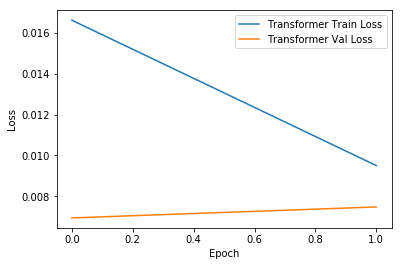

In [25]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')
plt.plot(transformer_val_losses, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [26]:
# save the model
torch.save(model.state_dict(), 'model/transformer_model.pth')